In [300]:
# !pip install ezodf
# !pip install fancyimpute
# ! pip install kmodes
# !pip install gower
# !pip install pyod
! pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 3.0 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.38.post1-cp312-cp312-macosx_11_0_arm64.whl size=705035 sha256=48a4a60032676f760840fa89fe1a7adec1d38030a3d7746a3b417f9e7f6d3106
  Stored in directory: /Users/rens/Library/Caches/pip/wheels/51/1c/fb/cfac6918bd6a1478ab55a3da03c501046b67b8161309c2f64a
Successfully built hdbscan


In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ezodf
import gower

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import KNNImputer
from fancyimpute import IterativeImputer
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
import hdbscan

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
def read_ods_file(file_path, sheet_name=0):
    ezodf.config.set_table_expand_strategy('all')  # Expand all rows and columns
    spreadsheet = ezodf.opendoc(file_path)
    sheet = spreadsheet.sheets[sheet_name]

    data = []
    for row in sheet.rows():
        row_data = [cell.value for cell in row]
        data.append(row_data)
    df = pd.DataFrame(data[1:], columns=data[0])
    
    return df

file_path = 'Machine Learning Challenge.ods'
raw_data = read_ods_file(file_path, sheet_name=0)
raw_data.head()

,consumer_id,gender,has_gender,has_first_name,has_last_name,has_email,has_dob,customer_age,account_age,account_last_updated,account_status,app_downloads,unique_offer_clicked,total_offer_clicks,unique_offer_impressions,total_offer_impressions,avg_redemptions,min_redemptions,max_redemptions,total_offers_redeemed
0,1284b75c-ecae-4015-8e3d-359c0347ede8,None,0.0,1.0,1.0,1.0,0.0,NaN,188.0,174.0,0.0,1.0,3.0,3.0,8.0,52.0,1.0,1.0,1.0,1.0
1,128af162-d2c3-4fe4-986c-359c8bdc6c04,None,0.0,1.0,1.0,1.0,0.0,NaN,185.0,174.0,0.0,1.0,3.0,8.0,5.0,58.0,1.0,1.0,1.0,1.0
2,12aada5e-36eb-4e9e-8d62-359c076c1b40,None,0.0,1.0,1.0,1.0,0.0,NaN,188.0,174.0,0.0,1.0,3.0,4.0,9.0,183.0,1.0,1.0,1.0,3.0
3,12c2e02f-bc79-4048-83ba-359cd3280dcf,None,0.0,1.0,1.0,1.0,0.0,NaN,184.0,174.0,0.0,1.0,3.0,7.0,4.0,56.0,1.0,1.0,1.0,1.0
4,12fabdf0-0582-489e-a6d3-35509ab8ae6f,f,1.0,1.0,1.0,1.0,1.0,22.0,572.0,173.0,0.0,1.0,4.0,6.0,7.0,83.0,1.0,1.0,1.0,3.0


In [66]:
df = raw_data.copy()
df = df.drop(['consumer_id', 'account_status'], axis=1) 

In [68]:
len(raw_data["consumer_id"].value_counts()) == raw_data.shape[0] # to indicate if consumer id repeats
# since they don't match, it could have the possibility of duplicate records

False

In [70]:
# duplicate = raw_data[raw_data.duplicated()]
# duplicate.shape

In [72]:
# distinct_consumers_count = df["consumer_id"].value_counts()
# repeated_consumers = distinct_consumers_count[distinct_consumers_count > 1].index.tolist()
# # repeated_consumers

In [74]:
# raw_data[raw_data["consumer_id"] == '91532ab0-a763-464b-a293-359cdbd0d058']

In [76]:
df.columns

Index(['gender', 'has_gender', 'has_first_name', 'has_last_name', 'has_email',
       'has_dob', 'customer_age', 'account_age', 'account_last_updated',
       'app_downloads', 'unique_offer_clicked', 'total_offer_clicks',
       'unique_offer_impressions', 'total_offer_impressions',
       'avg_redemptions', 'min_redemptions', 'max_redemptions',
       'total_offers_redeemed'],
      dtype='object')

In [78]:
# for i in df.columns:
#     if i != "consumer_id":
#         print(df[i].value_counts())
#         print()

In [80]:
df.isnull().sum()

gender                      4522
has_gender                     0
has_first_name                 0
has_last_name                  0
has_email                      0
has_dob                        0
customer_age                5936
account_age                    0
account_last_updated           0
app_downloads                  0
unique_offer_clicked           0
total_offer_clicks             0
unique_offer_impressions       0
total_offer_impressions        0
avg_redemptions                0
min_redemptions                0
max_redemptions                0
total_offers_redeemed          0
dtype: int64

## Data Pre-processing

In [84]:
le = LabelEncoder()

df['gender'] = le.fit_transform(df['gender'])
df['gender'] = df['gender'].replace(2, np.nan)

In [86]:
df["gender"].value_counts()

gender
1.0    2864
0.0    2614
Name: count, dtype: int64

In [88]:
# fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# # Account Age Histogram
# axes[0, 0].hist(df['account_age'], bins=30)
# axes[0, 0].set_title('Account Age Histogram')
# axes[0, 0].set_xlabel('Account Age')
# axes[0, 0].set_ylabel('Frequency')

# # Customer Age Histogram
# axes[0, 1].hist(df['customer_age'], bins=30)
# axes[0, 1].set_title('Customer Age Histogram')
# axes[0, 1].set_xlabel('Customer Age')
# axes[0, 1].set_ylabel('Frequency')

# # Log Transformation of Account Age Histogram
## df['account_age_log'] = np.log(df['account_age'] + 1)  # Add 1 to avoid log(0)
# axes[1, 0].hist(df['account_age_log'], bins=30)
# axes[1, 0].set_title('Log Transformed Account Age Histogram')
# axes[1, 0].set_xlabel('Log(Account Age)')
# axes[1, 0].set_ylabel('Frequency')

# # Log Transformation of Customer Age Histogram
## df['customer_age_log'] = np.log(df['customer_age'] + 1)  # Add 1 to avoid log(0)
# axes[1, 1].hist(df['customer_age_log'], bins=30)
# axes[1, 1].set_title('Log Transformed Customer Age Histogram')
# axes[1, 1].set_xlabel('Log(Customer Age)')
# axes[1, 1].set_ylabel('Frequency')

# plt.tight_layout()
# plt.show()


In [90]:
# 1. KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)
df_knn = df.copy()
df_knn[['gender', 'customer_age']] = knn_imputer.fit_transform(df_knn[['gender', 'customer_age']])
df_knn['gender'] = df_knn['gender'].apply(round)

# 2. MICE Imputation
mice_imputer = IterativeImputer(max_iter=10, random_state=42)
df_mice = df.copy()
df_mice[['gender', 'customer_age']] = mice_imputer.fit_transform(df_mice[['gender', 'customer_age']])
df_mice['gender'] = df_mice['gender'].apply(round)

# Handling non-negative values for log transformation (for customer_age and account_age)
df_knn['log_customer_age'] = np.log(df_knn['customer_age'] + 1) #np.log1p(df_knn['customer_age'])
df_knn['log_account_age'] = np.log(df_knn['account_age'] + 1) #np.log1p(df_knn['account_age']

df_mice['log_customer_age'] = np.log(df_mice['customer_age'] + 1)
df_mice['log_account_age'] = np.log(df_mice['account_age'] + 1)

In [92]:
# # Set up the 2x2 grid for KNN imputation
# fig, axs = plt.subplots(2, 2, figsize=(8,6))

# # Original customer_age (KNN imputed)
# sns.histplot(df_knn['customer_age'], kde=True, ax=axs[0, 0])
# axs[0, 0].set_title('KNN Imputed Customer Age')

# # Log-transformed customer_age
# sns.histplot(df_knn['customer_age_log'], kde=True, ax=axs[0, 1])
# axs[0, 1].set_title('Log Transformed Customer Age (KNN)')

# # Original account_age (KNN imputed)
# sns.histplot(df_knn['account_age'], kde=True, ax=axs[1, 0])
# axs[1, 0].set_title('KNN Imputed Account Age')

# # Log-transformed account_age
# sns.histplot(df_knn['account_age_log'], kde=True, ax=axs[1, 1])
# axs[1, 1].set_title('Log Transformed Account Age (KNN)')

# plt.tight_layout()
# plt.show()

In [94]:
# # Set up the 2x2 grid for MICE imputation
# fig, axs = plt.subplots(2, 2, figsize=(8,6))

# # Original customer_age (MICE imputed)
# sns.histplot(df_mice['customer_age'], kde=True, ax=axs[0, 0])
# axs[0, 0].set_title('MICE Imputed Customer Age')

# # Log-transformed customer_age
# sns.histplot(df_mice['customer_age_log'], kde=True, ax=axs[0, 1])
# axs[0, 1].set_title('Log Transformed Customer Age (MICE)')

# # Original account_age (MICE imputed)
# sns.histplot(df_mice['account_age'], kde=True, ax=axs[1, 0])
# axs[1, 0].set_title('MICE Imputed Account Age')

# # Log-transformed account_age
# sns.histplot(df_mice['account_age_log'], kde=True, ax=axs[1, 1])
# axs[1, 1].set_title('Log Transformed Account Age (MICE)')

# plt.tight_layout()
# plt.show()

In [96]:
#  MICE Imputation
mice_imputer = IterativeImputer(max_iter=10, random_state=42)
df_mice = df.copy()
df_mice[['gender', 'customer_age']] = mice_imputer.fit_transform(df_mice[['gender', 'customer_age']])
df_mice['gender'] = df_mice['gender'].apply(round)

df_mice['log_customer_age'] = np.log(df_mice['customer_age'] + 1)
df_mice['log_account_age'] = np.log(df_mice['account_age'] + 1)

#  Feature Engineering
df_mice['ctr'] = df_mice['total_offer_clicks'] / df_mice['total_offer_impressions']
df_mice['redemption_rate'] = df_mice['total_offers_redeemed'] / df_mice['total_offer_clicks']
df_mice['log_account_last_updated'] = np.log(df_mice['account_last_updated'])
df_mice['log_total_offer_impressions'] = np.log(df_mice['total_offer_impressions'])
df_mice['log_total_offer_clicks'] = np.log(df_mice['total_offer_clicks'])
df_mice['log_total_offers_redeemed'] = np.log(df_mice['total_offers_redeemed'])
df_mice['log_unique_offer_clicked'] = np.log(df_mice['unique_offer_clicked'])
df_mice['log_unique_offer_impressions'] = np.log(df_mice['unique_offer_impressions'])

df_mice = df_mice.drop(['customer_age',	'account_age', 'account_last_updated', 'total_offer_impressions', 
                        'total_offer_clicks', 'total_offers_redeemed', 'unique_offer_clicked', 'unique_offer_impressions'], axis=1)
df_mice.head()

,gender,has_gender,has_first_name,has_last_name,has_email,has_dob,app_downloads,avg_redemptions,min_redemptions,max_redemptions,log_customer_age,log_account_age,ctr,redemption_rate,log_account_last_updated,log_total_offer_impressions,log_total_offer_clicks,log_total_offers_redeemed,log_unique_offer_clicked,log_unique_offer_impressions
0,1,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,3.177367,5.241747,0.057692,0.333333,5.159055,3.951244,1.098612,0.000000,1.098612,2.079442
1,1,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,3.177367,5.225747,0.137931,0.125000,5.159055,4.060443,2.079442,0.000000,1.098612,1.609438
2,1,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,3.177367,5.241747,0.021858,0.750000,5.159055,5.209486,1.386294,1.098612,1.098612,2.197225
3,1,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,3.177367,5.220356,0.125000,0.142857,5.159055,4.025352,1.945910,0.000000,1.098612,1.386294
4,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.135494,6.350886,0.072289,0.500000,5.153292,4.418841,1.791759,1.098612,1.386294,1.945910


In [100]:
scaler = MinMaxScaler()
numerical_columns = df_mice.select_dtypes(include=['float64', 'int64']).columns.tolist()

df_mice[numerical_columns] = scaler.fit_transform(df_mice[numerical_columns])
df_mice.head()

,gender,has_gender,has_first_name,has_last_name,has_email,has_dob,app_downloads,avg_redemptions,min_redemptions,max_redemptions,log_customer_age,log_account_age,ctr,redemption_rate,log_account_last_updated,log_total_offer_impressions,log_total_offer_clicks,log_total_offers_redeemed,log_unique_offer_clicked,log_unique_offer_impressions
0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.200892,0.058651,0.043586,0.077098,0.074067,0.483318,0.266193,0.000000,0.416290,0.646015
1,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.200892,0.046457,0.107950,0.024660,0.074067,0.499517,0.503846,0.000000,0.416290,0.500000
2,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.200892,0.058651,0.014842,0.181973,0.074067,0.669970,0.335898,0.458157,0.416290,0.682606
3,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.200892,0.042349,0.097577,0.029155,0.074067,0.494311,0.471492,0.000000,0.416290,0.430677
4,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.180111,0.903911,0.055295,0.119048,0.000000,0.552682,0.434141,0.458157,0.525299,0.604531


In [102]:
df_mice['app_downloads'] = df_mice['app_downloads'].apply(lambda x: 1 if x == 1 else 0)

### Step 2: Clustering with K-Modes
has_columns = [col for col in df_mice.columns if col.startswith('has_')]
redemption_columns = [col for col in df_mice.columns if 'redemptions' in col]

# K-Modes Clustering for 'has_' columns
kmodes_has = KModes(n_clusters=2, init='Huang', n_init=5, verbose=1)
df_mice['has_cluster'] = kmodes_has.fit_predict(df_mice[has_columns])

# K-Modes Clustering for 'redemption' columns
kmodes_redemption = KModes(n_clusters=2, init='Huang', n_init=5, verbose=1)
df_mice['redemption_cluster'] = kmodes_redemption.fit_predict(df_mice[redemption_columns])

processed_data = df_mice.drop(has_columns + redemption_columns,axis=1)
processed_data.shape

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 8283.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1600, cost: 1855.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1600, cost: 1855.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1600, cost: 1855.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 8283.0
Best run was number 2
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 37, cost: 52.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 37, cost: 52.0
Init: initializing centroids
Init: initializing clusters
Starting iteration

(10000, 14)

In [43]:
processed_data.columns

Index(['gender', 'app_downloads', 'log_customer_age', 'log_account_age', 'ctr',
       'redemption_rate', 'log_account_last_updated',
       'log_total_offer_impressions', 'log_total_offer_clicks',
       'log_total_offers_redeemed', 'log_unique_offer_clicked',
       'log_unique_offer_impressions', 'has_cluster', 'redemption_cluster'],
      dtype='object')

In [188]:
# --- Local Outlier Factor (LOF) --- #
lof = LocalOutlierFactor()
lof_predictions = lof.fit_predict(processed_data)
lof_anomalies_indices = np.where(lof_predictions == -1)[0]

# --- Isolation Forest --- #
isf_clf = IsolationForest(contamination=len(lof_anomalies_indices)/processed_data.shape[0]) 
isf_clf.fit(processed_data)

isf_predictions = isf_clf.predict(processed_data)
isf_anomalies_indices = np.where(isf_predictions == -1)[0]

# --- DBSCAN --- #
dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan.fit(processed_data)

dbscan_predictions = dbscan.labels_
dbscan_anomalies_indices = np.where(dbscan_predictions == -1)[0]

# --- One-Class SVM --- #
ocsvm = OneClassSVM(nu=len(lof_anomalies_indices)/processed_data.shape[0], kernel="rbf")
ocsvm.fit(processed_data)
ocsvm_predictions = ocsvm.predict(processed_data)
ocsvm_anomalies_indices = np.where(ocsvm_predictions == -1)[0]


print(f"Local Outlier Factor (LOF): {len(lof_anomalies_indices)} anomalies detected")
print(f"Isolation Forest: {len(isf_anomalies_indices)} anomalies detected")
print(f"DBSCAN: {len(dbscan_anomalies_indices)} anomalies detected")
print(f"One-Class SVM: {len(ocsvm_anomalies_indices)} anomalies detected")

Local Outlier Factor (LOF): 620 anomalies detected
Isolation Forest: 620 anomalies detected
DBSCAN: 114 anomalies detected
One-Class SVM: 624 anomalies detected


In [190]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define Network parameters
input_dim = processed_data.shape[1]
encoding_dim = 6  
autoencoder = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)

data_tensor = torch.Tensor(processed_data.values) # Convert to PyTorch tensors

# Train the autoencoder
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = autoencoder(data_tensor)
    loss = criterion(outputs, data_tensor)
    loss.backward()
    optimizer.step()

# Calculate reconstruction errors
reconstructed_data = autoencoder(data_tensor).detach().numpy()
reconstruction_errors = np.mean(np.square(processed_data.values - reconstructed_data), axis=1)

# Identify anomalies
threshold = np.percentile(reconstruction_errors, 95)
autoencoders_anomalies_indices = np.where(reconstruction_errors > threshold)[0]
# print("Detected anomalies:", anomalies_indices)
print(f"Autoencoders: {len(autoencoders_anomalies_indices)} anomalies detected")

Autoencoders: 500 anomalies detected


In [192]:
processed_data.columns

Index(['gender', 'app_downloads', 'log_customer_age', 'log_account_age', 'ctr',
       'redemption_rate', 'log_account_last_updated',
       'log_total_offer_impressions', 'log_total_offer_clicks',
       'log_total_offers_redeemed', 'log_unique_offer_clicked',
       'log_unique_offer_impressions', 'has_cluster', 'redemption_cluster'],
      dtype='object')

In [194]:
processed_data.head()

,gender,app_downloads,log_customer_age,log_account_age,ctr,redemption_rate,log_account_last_updated,log_total_offer_impressions,log_total_offer_clicks,log_total_offers_redeemed,log_unique_offer_clicked,log_unique_offer_impressions,has_cluster,redemption_cluster
0,1.0,0,0.200892,0.058651,0.043586,0.077098,0.074067,0.483318,0.266193,0.000000,0.416290,0.646015,1,0
1,1.0,0,0.200892,0.046457,0.107950,0.024660,0.074067,0.499517,0.503846,0.000000,0.416290,0.500000,1,0
2,1.0,0,0.200892,0.058651,0.014842,0.181973,0.074067,0.669970,0.335898,0.458157,0.416290,0.682606,1,0
3,1.0,0,0.200892,0.042349,0.097577,0.029155,0.074067,0.494311,0.471492,0.000000,0.416290,0.430677,1,0
4,0.0,0,0.180111,0.903911,0.055295,0.119048,0.000000,0.552682,0.434141,0.458157,0.525299,0.604531,0,0


## Customer Segmentation

In [245]:
all_anomalies = set(isf_anomalies_indices.tolist() + dbscan_anomalies_indices.tolist() + ocsvm_anomalies_indices.tolist() + 
                    lof_anomalies_indices.tolist() + autoencoders_anomalies_indices.tolist())
anomalies_data = processed_data.loc[list(all_anomalies),:]
anomalies_data["customer_group"] = -1
# df_no_anomalies = df_processed.drop(all_anomalies, axis=0)
len(all_anomalies)/ processed_data.shape[0]

0.1496

In [212]:
df_no_anomalies = processed_data.drop(all_anomalies, axis=0)
df_no_anomalies.shape

(8504, 14)

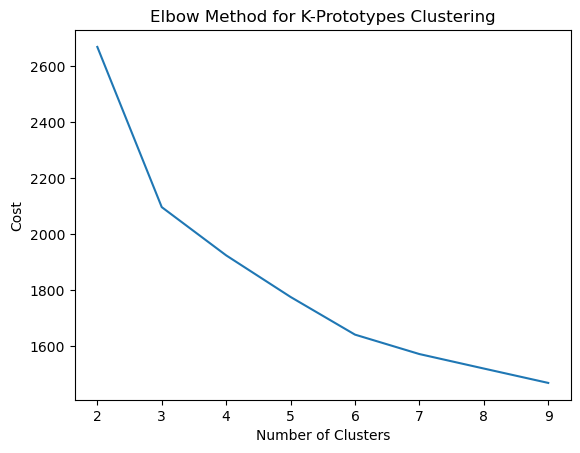

In [222]:
# Select categorical and numerical columns
categorical_columns = ['gender', 'app_downloads', 'has_cluster', 'redemption_cluster']
numerical_columns = [i for i in processed_data.columns if i not in categorical_columns]
columns_for_kproto = numerical_columns + categorical_columns

# Convert categorical columns to the appropriate type
df_kproto = df_no_anomalies.copy()
df_kproto[categorical_columns] = df_kproto[categorical_columns].astype('category')

# Finding optimal number of clusters using the Elbow method (cost function)
cost = []
for num_clusters in range(2, 10):
    kproto = KPrototypes(n_clusters=num_clusters, init='Huang', n_init=10, verbose=0)
    kproto.fit(df_kproto[columns_for_kproto], categorical=[df_kproto.columns.get_loc(col) for col in categorical_columns])
    cost.append(kproto.cost_)

# Plot the cost to find the elbow point
plt.plot(range(2, 10), cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for K-Prototypes Clustering')
plt.show()

In [274]:
# Now apply K-Prototypes with the optimal number of clusters (determine from the elbow plot)
optimal_clusters_kproto = 3
kproto = KPrototypes(n_clusters=optimal_clusters_kproto, init='Huang', n_init=10, verbose=1)
df_kproto['customer_group'] = kproto.fit_predict(df_kproto[columns_for_kproto], categorical=[df_kproto.columns.get_loc(col) for col in categorical_columns])
df_kproto['customer_group'].value_counts()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 2684, ncost: 2099.888782194401
Run: 1, iteration: 2/100, moves: 238, ncost: 2098.1976438117904
Run: 1, iteration: 3/100, moves: 12, ncost: 2098.188221190243
Run: 1, iteration: 4/100, moves: 5, ncost: 2098.1867823650023
Run: 1, iteration: 5/100, moves: 0, ncost: 2098.1867823650023
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 1596, ncost: 2109.0435707204538
Run: 2, iteration: 2/100, moves: 446, ncost: 2098.2062859394955
Run: 2, iteration: 3/100, moves: 187, ncost: 2096.3127792399805
Run: 2, iteration: 4/100, moves: 66, ncost: 2096.0907683439023
Run: 2, iteration: 5/100, moves: 17, ncost: 2096.076526166331
Run: 2, iteration: 6/100, moves: 4, ncost: 2096.075248658859
Run: 2, iteration: 7/100, moves: 0, ncost: 2096.075248658859
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3

customer_group
1    3290
0    3142
2    2072
Name: count, dtype: int64

In [257]:
kproto_result_df = pd.concat([df_kproto, anomalies_data], axis=0)
kproto_result_df["customer_group"].value_counts()

customer_group
 2    2482
 1    2342
 3    2072
 0    1608
-1    1496
Name: count, dtype: int64

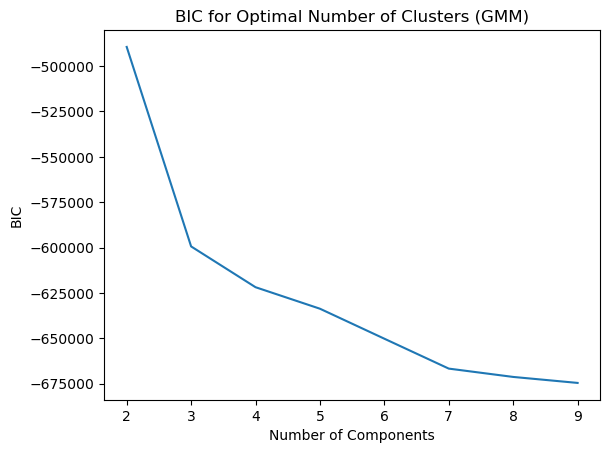

In [265]:
from sklearn.mixture import GaussianMixture
# from sklearn.preprocessing import OneHotEncoder
# import numpy as np

# # One-hot encode categorical features
# encoder = OneHotEncoder(sparse=False)
# encoded_categorical = encoder.fit_transform(df_no_anomalies[categorical_columns])

# Combine numerical and one-hot encoded categorical features
X_gmm = df_no_anomalies.values #np.hstack((df_no_anomalies[numerical_columns].values, encoded_categorical))

# Finding the optimal number of clusters using BIC
bic = []
for n in range(2, 10):
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=960)
    gmm.fit(X_gmm)
    bic.append(gmm.bic(X_gmm))

# Plot BIC values to find the optimal number of clusters
plt.plot(range(2, 10), bic)
plt.xlabel('Number of Components')
plt.ylabel('BIC')
plt.title('BIC for Optimal Number of Clusters (GMM)')
plt.show()

In [271]:
# Apply GMM with the optimal number of components
df_gmm = df_no_anomalies.copy()
optimal_clusters_gmm = 3
gmm = GaussianMixture(n_components=optimal_clusters_gmm, covariance_type='full', random_state=960)
df_gmm['customer_group'] = gmm.fit_predict(X_gmm)

gmm_result_df = pd.concat([df_gmm, anomalies_data], axis=0)
gmm_result_df["customer_group"].value_counts()

customer_group
 1    3714
 2    2718
 0    2072
-1    1496
Name: count, dtype: int64

/var/folders/z6/47hkfr6s6d1_cchpbbsz96k40000gn/T/ipykernel_40649/1035165887.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(gower_dist, method='average')


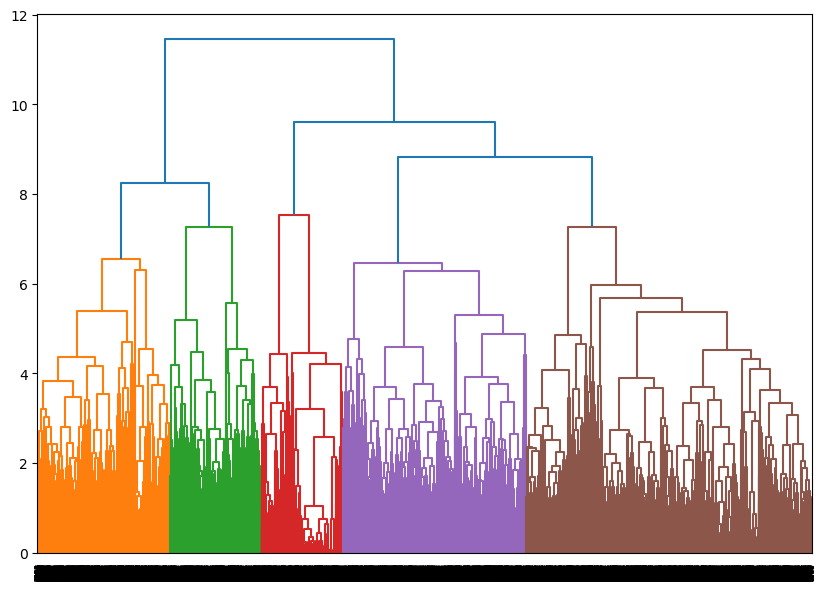

In [296]:
# #Compute Gower distance matrix and compute clusters
# gower_dist = gower.gower_matrix(df_no_anomalies)

# agglo = AgglomerativeClustering(n_clusters=None, distance_threshold=0, metric='precomputed', linkage='complete')
# agglo_clusters = agglo.fit_predict(gower_dist)

# Create a dendrogram to visualize the cluster hierarchy
Z = linkage(gower_dist, method='average')
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.show()

In [294]:
# Choose an optimal number of clusters based on the dendrogram
optimal_clusters_agglo = 5
df_hierarchical = df_no_anomalies.copy()
agglo = AgglomerativeClustering(n_clusters=optimal_clusters_agglo, metric='precomputed', linkage='complete')
df_hierarchical['customer_group'] = agglo.fit_predict(gower_dist)

hierarchical_result_df = pd.concat([df_hierarchical, anomalies_data], axis=0)
hierarchical_result_df["customer_group"].value_counts()

customer_group
 2    2511
 0    2072
 1    1741
-1    1496
 4    1203
 3     977
Name: count, dtype: int64

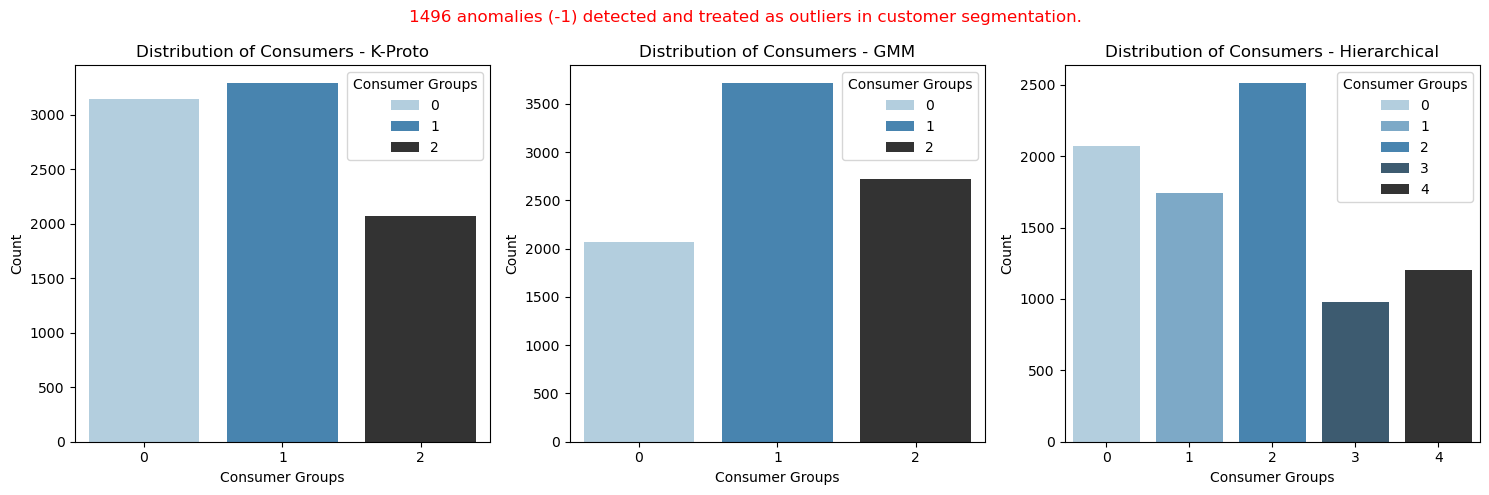

In [329]:
anomaly_count = anomalies_data.shape[0]

# # Filter out anomalies (rows with -1)
# df_no_anomalies = df[df.apply(lambda x: x != -1)]

# Plot 1x3 barplots for each variable excluding -1 (now filtered out)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Titles for each variable
data_ = [df_kproto, df_gmm, df_hierarchical]
data_names = ["K-Proto","GMM","Hierarchical"]


for i, data in enumerate(data_):
    sns.countplot(x=data["customer_group"], ax=axes[i], hue=data["customer_group"], palette="Blues_d")
    axes[i].set_title(f'Distribution of Consumers - {data_names[i]}')
    axes[i].set_xlabel('Consumer Groups')
    axes[i].set_ylabel('Count')
    axes[i].get_legend().set_title("Consumer Groups")

# Add a note in the figure about anomalies
fig.suptitle(f'{anomaly_count} anomalies (-1) detected and treated as outliers in customer segmentation.', fontsize=12, color='red')

plt.tight_layout()
plt.show()

In [321]:
# dir(data)